# Forward Propagation Code

The code below implements a simulation of the attenuation and post-interaction propagation of an incident plane wave with an electric field of the form $E(z,t) = E_0e^{i(\tilde{k}z - \omega{t})}$, where $\tilde{k}$ is the complex wave-vector defined by $\frac{\omega}{\tilde{k}} = \frac{c}{\tilde{n}}$ and $\tilde{n} = 1 - \delta + i\beta$. Rearranging this gives
$$\tilde{k} = \frac{\omega}{c}(1 - \delta + i\beta)$$
For clarity, we split the real and imaginary parts and define $\tilde{k} = k + i\kappa$ with
$$k \equiv \text{Re}[\tilde{k}] = \frac{\omega}{c}(1 - \delta)$$
$$\kappa \equiv \text{Im}[\tilde{k}] = \frac{\omega}{c}\beta$$
The wave is generally given by $E(z,t) = E_0e^{i(kz-\omega{t})}e^{-\kappa{z}}$. Plugging in the above definitions gives us a form that is conveniently separated into the contributions of different effects:
$$
\begin{align}
E(z,t) &= E_0e^{i(\frac{\omega}{c}(1-\delta)z-\omega{t})}e^{-\omega\beta z/c}\\
       &= \underbrace{E_0e^{i\omega(z/c - t)}}_{\text{vacuum propagation}}\ 
          \underbrace{e^{-i\varepsilon\delta z/\hbar c}}_{\text{phase-shift}}\ 
          \underbrace{e^{-\varepsilon\beta z/\hbar c}}_{\text{attenuation}}
\end{align}
$$
where the last step uses $\varepsilon = \hbar\omega$, the energy of incident beam. The first exponential represents the phase progression of the wave as if it were travelling through vacuum, the second factor represents the phase accumulated by propagation within a medium, and the last factor represents the amplitude attenuation of the wave.

The average beam intensity is proportional to the square of the electric field, which cancels the contributions of the complex exponentials in the final expression:
$$
\begin{align}
\bar{I} &= \frac{1}{2}\text{Re}[\tilde{n}]\sqrt{\frac{\epsilon_0}{\mu_0}}|E(z,t)|^2 \\
        &= \frac{1}{2}\text{Re}[\tilde{n}]\sqrt{\frac{\epsilon_0}{\mu_0}}|E_0|^2e^{-2\varepsilon\beta z/\hbar c} \\
        &= \bar{I_0}e^{-(2\varepsilon\beta/\hbar c)z}
\end{align}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# class Beam:
    
#     ## Physical constants
#     h = 6.6260701e-34    # J.s: Planck's constant
#     c = 2.99792458e8     # m/s: Speed of light
    
#     def __init__(self, energy = 9.61306e-16, distance = 100e-3):
#         self.energy     = energy       # [J]
#         self.wavelength = h*c/self.E   # [m]
#         self.frequency  = self.E/h     # [Hz]
#         self.distance   = distance     # [m]
    
#     def get_planewave(self, K, nbins_x, nbins_y, z0 = 0.):
#         '''
#         Returns an array of the plane wave sampled at nbins_x * nbins_y points.
#         Args:
#             K   (complex): complex refractive index (or just the real part)
#             nbins_x (int): number of bins in the x direction
#             nbins_y (int): number of bins in the y direction
#             z0    (float): initial beam position w.r.t. origin
#         returns:
#             planewave (ndarray): plane wave array of size nbins_x * nbins_y
#         '''
#         wave = np.exp(1j * K.real * z0)
#         planewave = np.full((nbins_x+1,nbins_y+1), wave, dtype = np.complex128)
#         return planewave

In [3]:
# class absorber(self):
    
#     shapes = ['sphere', 'cylinder']
    
#     def __init__(self, shape, angles = [0.,0.,0.]):
#         self.shape  = shape
#         self.angles = angles
        

In [6]:
def SphericalThickness(x,y,args):
    '''
    Returns thickness through sphere of radius r at a given (x,y)
    '''
    r = args['r']
    if x**2 + y**2 < r**2:
        return np.sqrt(r**2 - (x**2 + y**2)) * 2
    else:
        return 0.


def attenuation_pw(t_func, shape_args, z0, E, delta, beta, Lx, Ly, nbins_x, nbins_y, norm = False):
    '''
    Inputs:
        t_func (callable): function defining the thickness at (x,y)
        shape_args (dict): arguments specifying the shape's dimensional parameters
        z0        (float): starting z-position of incident plane wave
        E         (float): incident beam energy [J]
        delta     (float): 1 + real part of refractive index
        beta      (float): imaginary part of refractive index
        Lx        (float): image field x-length
        Ly        (float): image field y-length
        nbins_x     (int): number of x bins
        nbins_y     (int): number of y bins
        norm       (bool): if True, normalizes the output grid
    Outputs:
        attenuated_wave (ndarray): xy grid of waveform values post-attenuation
    '''
    ## Physical constants
    h = 6.6260701e-34    # [J.s]: Planck's constant
    hbar = h/(2*np.pi)
    c = 2.99792458e8     # [m/s]: Speed of light

    ## Material-specific constants
    N = 1 - delta + 1j*beta      # Complex refractive index
    omega = E/hbar               # [1/s]: Angular frequency
    d_phi = (E*delta) / (hbar*c) # phase-shift factor
    d_amp = (E*beta) / (hbar*c)  # attenuation factor
    
    ## Discretization parameters
    dx = Lx/nbins_x      # Spacing between x grid-points
    dy = Ly/nbins_y      # Spacing between y grid-points

    ## Initialize the attenuated wave as a uniform plane wave in the +z direction starting at z0
    attenuated_wave = np.full((nbins_x+1,nbins_y+1), np.exp(1j * (omega/c) * z0), dtype = np.complex128)

    ## Multiply the wave in each grid-point by the appropriate attenuation factor
    for i in range(nbins_x + 1):
        x = (i - nbins_x/2) * dx       # maps index i to coordinate x
        
        for j in range(nbins_y + 1):
            y = (j - nbins_y/2) * dy       # maps index j to coordinate y
            
            t = t_func(x, y, shape_args)       # thickness at entry point (x,y)

            # Propagate the wave pixels by their respective phases and attenuate
            attenuated_wave[i,j] *= np.exp(-(d_amp + 1j*d_phi) * t)
    
    if norm:
        return attenuated_wave / np.sqrt(sum(sum(attenuated_wave)))
    else:
        return attenuated_wave



def propagate(wave, E, d, mode = 'full', norm = False):
    '''
    Propagates a wave via convolution.
    Args:
        wave (ndarray): 2D array of the (discretized) wave to be propagated
        E      (float): wave energy
        d      (float): distance to propagate the wave
        norm    (bool): if True, normalizes the output grid
    '''
    ## Physical constants
    h = 6.6260701e-34    # J.s: Planck's constant
    c = 2.99792458e8     # m/s: Speed of light

    ## Vacuum wavelength and wavevector
    lambda_vac = h*c/E            # [m]: wavelength
    k_vac = 2*np.pi/lambda_vac    # [1/m]: wavevector
    
    dim = wave.shape
    filt = np.zeros_like(wave, dtype = np.complex128)
    
    for i in range(dim[0]):
        x = (i - nbins_x/2) * dx       # maps index i to coordinate x
        
        for j in range(dim[1]):
            y = (j - nbins_y/2) * dy       # maps index j to coordinate y
            
            filt[i][j] += np.exp(-1j * k_vac * (x**2 + y**2) / (2*d))

    ## Propagate the wave through convolution
    prefactor = -1j * np.exp(1j * k_vac * d) / (lambda_vac * d)
    propagated_wave = prefactor * signal.convolve2d(filt, wave, mode = mode)
        
    if norm:
        return propagated_wave / np.sqrt(sum(sum(propagated_wave)))
    else:
        return propagated_wave

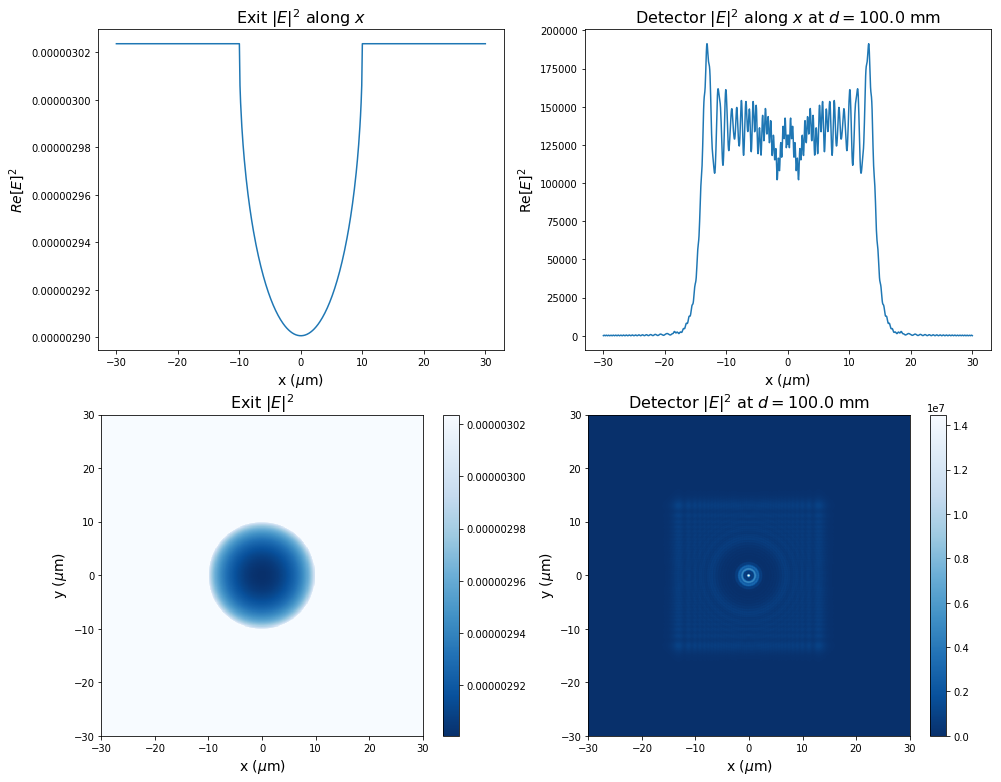

In [8]:
eV2J   = 1.60217662e-19      # [J/eV]

## Physical parameters
radius = 10e-6               # m: sphere radius
args   = {'r': radius}
d      = 100e-3              # m: camera z-distance from far edge of sphere
Lx     = 60e-6               # m: image field x-length
Ly     = 60e-6               # m: image field y-length
E0     = 5928.44775          # [eV]
delta = 1.51026588e-05
beta  = 3.45463604e-08

## Discretization parameters
nbins_x  = 600             # Number of x bins
nbins_y  = 600             # Number of y bins
dx       = Lx/nbins_x      # Spacing between x grid-points
dy       = Ly/nbins_y      # Spacing between y grid-points

attenuated_wave = attenuation_pw(t_func = SphericalThickness, shape_args = args, z0 = -radius,
                                 E = E0*eV2J, delta = delta, beta = beta,
                                 Lx = Lx, Ly = Ly, nbins_x = nbins_x, nbins_y = nbins_y, norm = True)
propagated_wave = propagate(wave = attenuated_wave, E = E0*eV2J, d = d, mode = 'full', norm = True)

## Plotting
fig = plt.figure(figsize = (16,13))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

att_dim  = attenuated_wave.shape
prop_dim = propagated_wave.shape

x1 = np.linspace(-nbins_x/2, nbins_x/2, att_dim[0]) * dx * 1e6
y1 = np.linspace(-nbins_y/2, nbins_y/2, att_dim[1]) * dy * 1e6
ax1.plot(x1, abs(attenuated_wave[int(nbins_x/2),:])**2 ) # Selects a line along x
# ax1.plot(x1, (attenuated_wave[int(nbins_x/2),:].real)**2 ) # Selects a line along x
ax1.set_xlabel('x ($\mu$m)', fontsize = 14)
# ax1.set_ylabel('$|E|^2$', fontsize = 14)
ax1.set_ylabel('$Re[E]^2$', fontsize = 14)
ax1.set_title('Exit $|E|^2$ along $x$', fontsize = 16)
# ax1.set_title('Exit Re$[E]^2$ along $x$', fontsize = 16)

x2 = np.linspace(-nbins_x/2, nbins_x/2, prop_dim[0]) * dx * 1e6
y2 = np.linspace(-nbins_y/2, nbins_y/2, prop_dim[1]) * dy * 1e6
ax2.plot(x2, abs(propagated_wave[int(nbins_x/2),:])**2 ) # Selects a line along x
# ax2.plot(x2, (propagated_wave[int(nbins_x/2),:].real)**2 ) # Selects a line along x
ax2.set_xlabel('x ($\mu$m)', fontsize = 14)
# ax2.set_ylabel('$|E|^2$', fontsize = 14)
ax2.set_ylabel('Re$[E]^2$', fontsize = 14)
ax2.set_title('Detector $|E|^2$ along $x$ at $d=$'+str(d*1e3)+' mm', fontsize = 16)
# ax2.set_title('Detector Re$[E]^2$ along $x$ at $d=$'+str(d*1e3)+' mm', fontsize = 16)

ax3 = fig.add_subplot(223, aspect = 'equal')
ax4 = fig.add_subplot(224, aspect = 'equal')

im1 = ax3.pcolormesh(x1, y1, abs(attenuated_wave)**2, cmap = 'Blues_r')
# im1 = ax3.pcolormesh(x1, y1, (attenuated_wave.real)**2, cmap = 'Blues_r')
fig.colorbar(im1, ax = ax3)
ax3.set_xlabel('x ($\mu$m)', fontsize = 14)
ax3.set_ylabel('y ($\mu$m)', fontsize = 14)
ax3.set_title('Exit $|E|^2$', fontsize = 16)
# ax3.set_title('Exit Re$[E]^2$', fontsize = 16)

im2 = ax4.pcolormesh(x2, y2, abs(propagated_wave)**2, cmap = 'Blues_r')
# im2 = ax4.pcolormesh(x2, y2, (propagated_wave.real)**2, cmap = 'Blues_r')
fig.colorbar(im2, ax = ax4)
ax4.set_xlabel('x ($\mu$m)', fontsize = 14)
ax4.set_ylabel('y ($\mu$m)', fontsize = 14)
ax4.set_title('Detector $|E|^2$ at $d=$'+str(d*1e3)+' mm', fontsize = 16)
# ax4.set_title('Detector Re$[E]^2$ at $d=$'+str(d*1e3)+' mm', fontsize = 16)

plt.show()

Now let's try a cylinder

In [94]:
def CylindricalThickness(x,y,args):
    '''
    Returns thickness through a horizontal cylinder
    of radius r and height h at a given (x,y)
    '''
    r = args['r']
    h = args['h']
    if y**2 < r**2 and abs(x) < h:
        return np.sqrt(r**2 - y**2) * 2
    else:
        return 0.

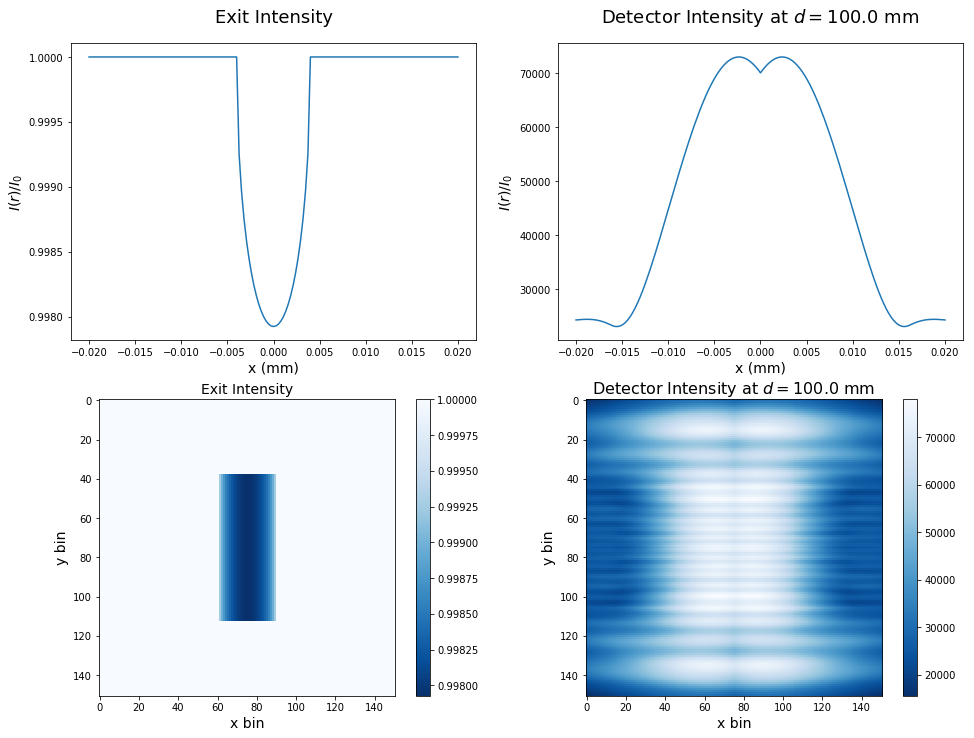

In [105]:
eV2J   = 1.60217662e-19       # [J/eV]

## Physical parameters
radius = 1e-6                # [m]: cylinder radius
height = 10e-6               # [m]: cylinder height
args   = {'r': radius, 'h': height}
d      = 100e-3               # [m]: camera z-distance from edge of cylinder
Lx     = 40e-6               # [m]: image field x-length
Ly     = 10e-6               # [m]: image field y-length
E0     = 5928.44775           # [keV]: incident beam energy
delta = 1.51026588e-05
beta  = 3.45463604e-08

## Discretization parameters
nbins_x  = 150             # Number of x bins
nbins_y  = 150             # Number of y bins
dx       = Lx/nbins_x      # Spacing between x grid-points
dy       = Ly/nbins_y      # Spacing between y grid-points


attenuated_wave = attenuation_pw(t_func = CylindricalThickness, shape_args = args, z0 = -args['r'],
                                 E = E0*eV2J, delta = delta, beta = beta,
                                 Lx = Lx, Ly = Ly, nbins_x = nbins_x, nbins_y = nbins_y)
propagated_wave = propagate(attenuated_wave, E0*eV2J, d, mode = 'same')


## Plotting
fig = plt.figure(figsize = (16,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

att_dim  = attenuated_wave.shape
prop_dim = propagated_wave.shape

x1 = np.linspace(-nbins_x/2, nbins_x/2, att_dim[0]) * dx * 1e3
ax1.plot(x1, np.abs(attenuated_wave[int(nbins_x/2),:]))
ax1.set_xlabel('x (mm)', fontsize = 14)
ax1.set_ylabel('$I(r)/I_0$', fontsize = 14)
ax1.set_title('Exit Intensity', fontsize = 18, y = 1.05)

x2 = np.linspace(-nbins_x/2, nbins_x/2, prop_dim[0]) * dx * 1e3
ax2.plot(x2, np.abs(propagated_wave[int(nbins_x/2),:]))
ax2.set_xlabel('x (mm)', fontsize = 14)
ax2.set_ylabel('$I(r)/I_0$', fontsize = 14)
ax2.set_title('Detector Intensity at $d=$'+str(d*1e3)+' mm', fontsize = 18, y = 1.05)

ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

im1 = ax3.imshow(abs(attenuated_wave), cmap = 'Blues_r')
fig.colorbar(im1, ax = ax3)
ax3.set_title('Exit Intensity', fontsize = 14)
ax3.set_xlabel('x bin', fontsize = 14)
ax3.set_ylabel('y bin', fontsize = 14)

im2 = ax4.imshow(abs(propagated_wave), cmap = 'Blues_r')
fig.colorbar(im2, ax = ax4)
ax4.set_title('Detector Intensity at $d=$'+str(d*1e3)+' mm', fontsize = 16)
ax4.set_xlabel('x bin', fontsize = 14)
ax4.set_ylabel('y bin', fontsize = 14)


plt.show()

Now, a cone:

In [97]:
def ConeThickness(x,y,args):
    '''
    Returns thickness through a horizontal right-opening
    cone of height h and half-angle theta at a given (x,y)
    '''
    h = args['h']
    theta = args['theta']
    
    r = abs(x) * np.tan(theta) # radius of circular cone slice
    
    if abs(y) < r and x < h and x > 0:
        return np.sqrt(r**2 - y**2) * 2
    else:
        return 0.

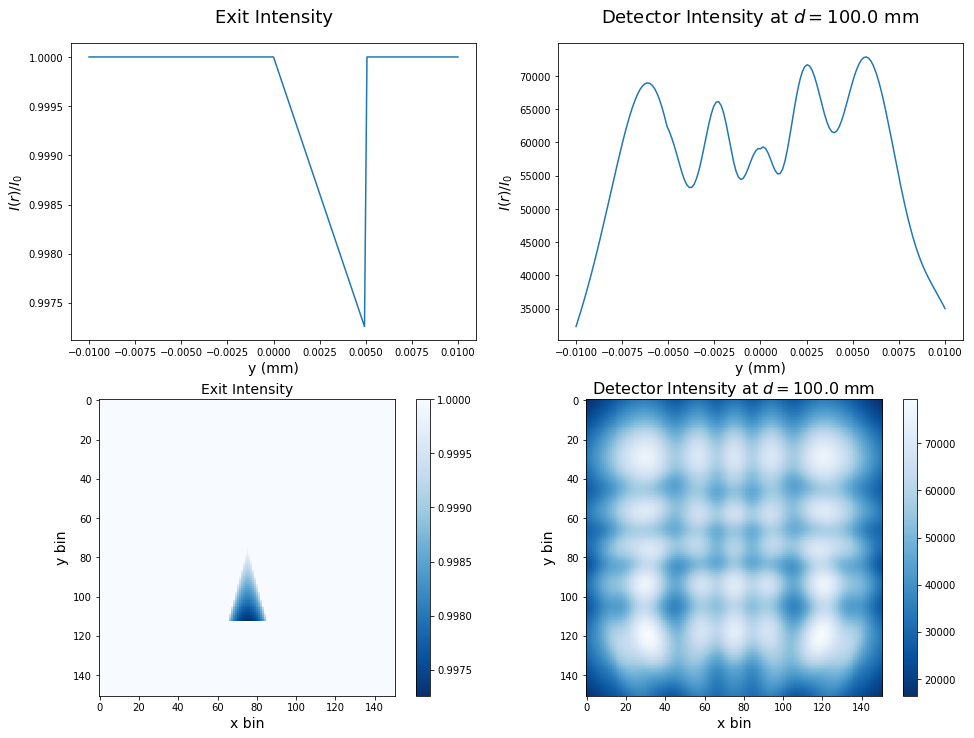

In [107]:
eV2J   = 1.60217662e-19       # [J/eV]

## Physical parameters
height = 5e-6               # [m]: cylinder height
theta  = 15 * np.pi/180      # [rad]: cone half-angle
args   = {'h': height, 'theta': theta}
d      = 100e-3               # [m]: camera z-distance from edge of cylinder
Lx     = 20e-6               # [m]: image field x-length
Ly     = 20e-6               # [m]: image field y-length
E0     = 5928.44775           # [keV]: incident beam energy
delta = 1.51026588e-05
beta  = 3.45463604e-08

## Discretization parameters
nbins_x  = 150             # Number of x bins
nbins_y  = 150             # Number of y bins
dx       = Lx/nbins_x      # Spacing between x grid-points
dy       = Ly/nbins_y      # Spacing between y grid-points


attenuated_wave = attenuation_pw(t_func = ConeThickness, shape_args = args, z0 = -args['h']*np.tan(args['theta']),
                                 E = E0*eV2J, delta = delta, beta = beta,
                                 Lx = Lx, Ly = Ly, nbins_x = nbins_x, nbins_y = nbins_y)
propagated_wave = propagate(attenuated_wave, E0*eV2J, d, mode = 'same')

## Plotting
fig = plt.figure(figsize = (16,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

att_dim  = attenuated_wave.shape
prop_dim = propagated_wave.shape

x1 = np.linspace(-nbins_x/2, nbins_x/2, att_dim[0]) * dx * 1e3
ax1.plot(x1, np.abs(attenuated_wave[:,int(nbins_x/2)]))
ax1.set_xlabel('y (mm)', fontsize = 14)
ax1.set_ylabel('$I(r)/I_0$', fontsize = 14)
ax1.set_title('Exit Intensity', fontsize = 18, y = 1.05)

x2 = np.linspace(-nbins_x/2, nbins_x/2, prop_dim[0]) * dx * 1e3
ax2.plot(x2, np.abs(propagated_wave[:,int(nbins_x/2)]))
ax2.set_xlabel('y (mm)', fontsize = 14)
ax2.set_ylabel('$I(r)/I_0$', fontsize = 14)
ax2.set_title('Detector Intensity at $d=$'+str(d*1e3)+' mm', fontsize = 18, y = 1.05)

ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

im1 = ax3.imshow(abs(attenuated_wave), cmap = 'Blues_r')
fig.colorbar(im1, ax = ax3)
ax3.set_title('Exit Intensity', fontsize = 14)
ax3.set_xlabel('x bin', fontsize = 14)
ax3.set_ylabel('y bin', fontsize = 14)

im2 = ax4.imshow(abs(propagated_wave), cmap = 'Blues_r')
fig.colorbar(im2, ax = ax4)
ax4.set_title('Detector Intensity at $d=$'+str(d*1e3)+' mm', fontsize = 16)
ax4.set_xlabel('x bin', fontsize = 14)
ax4.set_ylabel('y bin', fontsize = 14)

plt.savefig('Cone1.png')
plt.savefig('Cone2.png')
plt.savefig('Cone3.png')
plt.savefig('Cone4.png')

plt.show()

## Code for polychromatic waves from harmonics

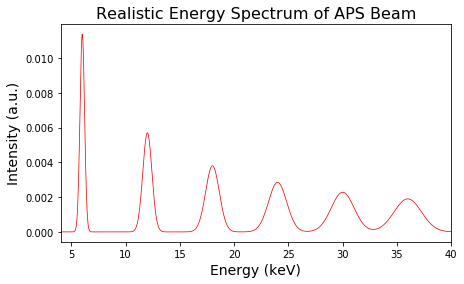

In [29]:
def gaussian(x,mu,sigma):
    return ( 1/(np.sqrt(2*np.pi*(sigma**2))) ) * np.exp( -( ((x-mu)/sigma)**2 )/2)

def makeGaussianHarmonics(E0, N_harmonics, N_samples, E_lim = None, sigmas = None):
    ''' Returns a normalized intensity distribution of Gaussians
        centered at harmonics of E0.'''
    centroids = [i*E0 for i in range(1,N_harmonics+2)]

    if sigmas is None:
        sigmas = [0.035*E for E in centroids]

    if E_lim is None:
        energy_axis = np.linspace(E0 * 0.5, E0 * 1.5, N_samples)
    else:
        energy_axis = np.linspace(E_lim[0], E_lim[1], N_samples)
        
    beam_profile = 0
    for n,E in enumerate(centroids):
        beam_profile += gaussian(energy_axis, centroids[n], sigmas[n])

    beam_profile /= sum(beam_profile) # normalize the profile
    
    return [energy_axis, beam_profile]

E0 = 6.0
energy_axis, beam_profile = makeGaussianHarmonics(E0, 5, 1000, E_lim = [4.0, 40.0])

fig = plt.figure(figsize = (7,4))
ax  = fig.add_subplot(111)
ax.plot(energy_axis, beam_profile, 'r-', lw = 0.75)
ax.set_xlim([4,40])
ax.set_xlabel('Energy (keV)', fontsize = 14)
ax.set_ylabel('Intensity (a.u.)', fontsize = 14)
ax.set_title('Realistic Energy Spectrum of APS Beam', fontsize = 16)
plt.savefig('APS_Spectrum.png')
plt.show()

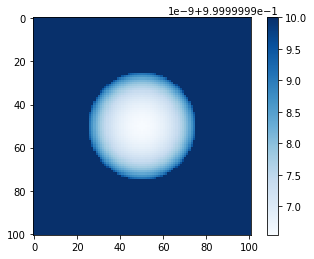

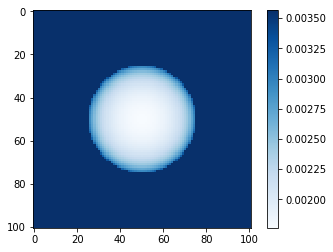

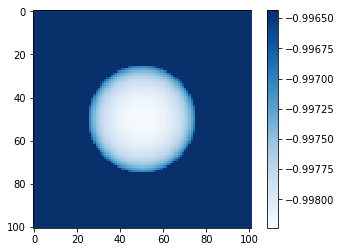

In [262]:
## Physical parameters
radius = 25e-3                # m: sphere radius
d      = 100e-3               # m: camera distance from edge of sphere
Lx     = 100e-3               # m: image field x-length
Ly     = 100e-3               # m: image field y-length
eV2J   = 1.60217662e-19       # [J/eV]
E0     = 5928.44775           # [keV]
# E0 = 9.61306e-16            # [J]: incident x-ray energy (= 6keV)

## Discretization parameters
nbins_x  = 100             # Number of x bins
nbins_y  = 100             # Number of y bins
dx       = Lx/nbins_x      # Spacing between x grid-points
dy       = Ly/nbins_y      # Spacing between y grid-points

## Import refractive index data as a function of energy
data = np.loadtxt('heptane_refr_indices.txt', skiprows = 2)
E_refr, delta_refr, beta_refr = (data[:,0], data[:,1], data[:,2])

energy_axis, beam_profile = makeGaussianHarmonics(E0 = E0, N_harmonics = 5, N_samples = 1000, E_lim = [4.0,40.0])

weighted_waves = [None] * len(energy_axis)

for i,E in enumerate(energy_axis):
    if 
    weighted_waves[i] = attenuation_pw(SphericalThickness, E*eV2J, delta, beta, radius, Lx, Ly, nbins_x, nbins_y) * beam_profile[i]

full_wave = sum(weighted_waves)

plt.imshow(np.abs(aw), cmap = 'Blues_r')
plt.colorbar()
plt.show()

plt.imshow(np.abs(full_wave), cmap = 'Blues_r')
plt.colorbar()
plt.show()

plt.imshow(np.abs(full_wave) - np.abs(aw), cmap = 'Blues_r')
plt.colorbar()
plt.show()

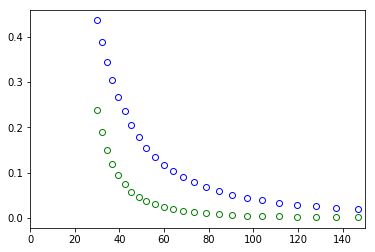

In [89]:
## Import refractive index data as a function of energy
data = np.loadtxt('heptane_refr_indices.txt', skiprows = 2)
E_refr, delta_refr, beta_refr = (data[:,0], data[:,1], data[:,2])
plt.plot(E_refr, delta_refr, 'bo', mfc='none')
plt.plot(E_refr, beta_refr, 'go', mfc='none')

# Found this at https://refractiveindex.info/
n_of_lambda = lambda lam: 1.38248838 + 4.05375e-3/lam + 4.58433e-3/(lam**2)
h = 6.6260701e-34    # J.s: Planck's constant
c = 2.99792458e8     # m/s: Speed of light
eV2J   = 1.60217662e-19       # [J/eV]
# plt.plot(E_refr, n_of_lambda(h*c/(E_refr))/5e22, 'r-')
# plt.plot(E_refr[E_refr>3000], np.exp(-E_refr[E_refr>3000]), 'r-')
# plt.plot(E_refr, 1/E_refr - 1/(E_refr**2), 'r-')
plt.xlim([0,150])

plt.show()

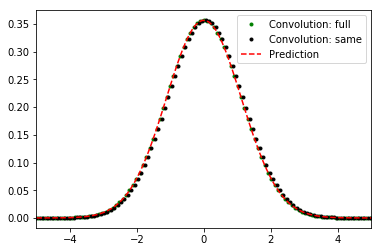

In [157]:
xmin, xmax, n_samples = [-5,5,100]
x = np.linspace(xmin,xmax,n_samples)
sigma1 = 1
sigma2 = 1/2
mu1 = 0
mu2 = 0
y_gauss_1 = gaussian(x,mu1,sigma1)
y_gauss_2 = gaussian(x,mu2,sigma2)
# plt.plot(x, y_gauss_1, 'o-', label = 'Gaussian 1')
# plt.plot(x, y_gauss_2, 'o-', label = 'Gaussian 2')

# mode = full
conv_gauss = np.convolve(y_gauss_1, y_gauss_2, mode = 'full')
conv_gauss /= np.sqrt(sum(conv_gauss)) # normalize the distribution
x_conv = np.linspace(xmin*2, xmax*2, n_samples*2 - 1)
plt.plot(x_conv, conv_gauss, 'g.', label = 'Convolution: full')

# mode = same
conv_gauss = np.convolve(y_gauss_1, y_gauss_2, mode = 'same')
conv_gauss /= np.sqrt(sum(conv_gauss)) # normalize the distribution
plt.plot(x, conv_gauss, 'k.', label = 'Convolution: same')


conv_prediction = gaussian(x, 0, np.sqrt(sigma1**2 + sigma2**2))
plt.plot(x,conv_prediction, 'r--', label = 'Prediction')

plt.legend()
plt.xlim([xmin,xmax])
plt.show()


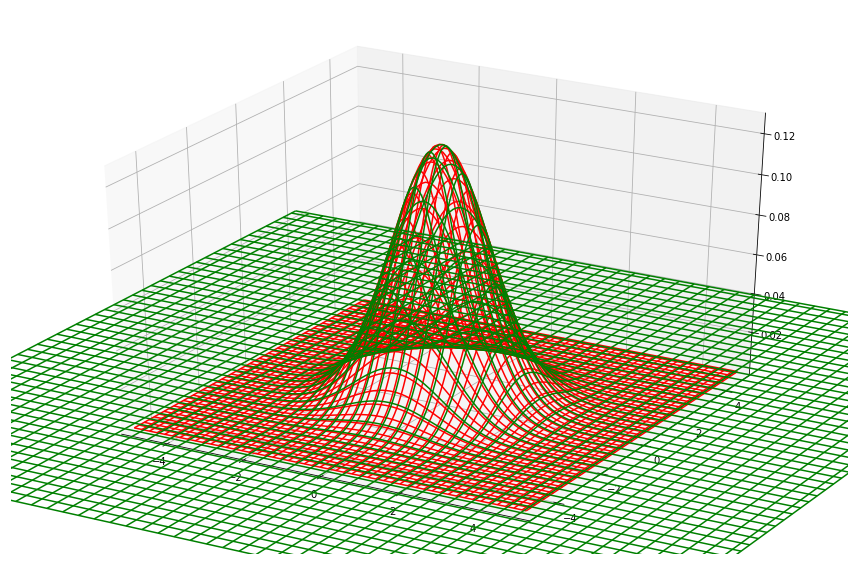

In [160]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal

xmin, xmax, n_xsamples = [-5,5,100]
ymin, ymax, n_ysamples = [-5,5,100]

sigma1 = 1
sigma2 = 1/2
mu1 = 0
mu2 = 0

x = np.linspace(xmin,xmax,n_xsamples)
y = np.linspace(ymin,ymax,n_ysamples)

X,Y = np.meshgrid(x,y)

Z_gauss_1 = np.zeros_like(X)
Z_gauss_2 = np.zeros_like(X)
for i,xval in enumerate(x):
    for j,yval in enumerate(y):
        Z_gauss_1[i,j] = gaussian(xval,mu1,sigma1) * gaussian(yval,mu1,sigma1)
        Z_gauss_2[i,j] = gaussian(xval,mu2,sigma2) * gaussian(yval,mu2,sigma2)

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection = '3d')

# ax.plot_surface(X, Y, Z_gauss_1, label = 'Gaussian 1')
# ax.plot_surface(X, Y, Z_gauss_2, label = 'Gaussian 2')

# mode = full
conv_gauss = signal.convolve2d(Z_gauss_1, Z_gauss_2, mode = 'full')
conv_gauss /= np.sqrt(sum(sum(conv_gauss))) # normalize the distribution
x_conv = np.linspace(xmin*2, xmax*2, n_xsamples*2 - 1)
y_conv = np.linspace(ymin*2, ymax*2, n_ysamples*2 - 1)
X_conv,Y_conv = np.meshgrid(x_conv,y_conv)
ax.plot_wireframe(X_conv, Y_conv, conv_gauss, color = 'g', label = 'Convolution: full')

# mode = same
conv_gauss = signal.convolve2d(Z_gauss_1, Z_gauss_2, mode = 'same')
conv_gauss /= np.sqrt(sum(sum(conv_gauss))) # normalize the distribution
# ax.plot_wireframe(X, Y, conv_gauss, color = 'k', label = 'Convolution: same')



conv_prediction = np.zeros_like(X)
for i,xval in enumerate(x):
    for j,yval in enumerate(y):
        conv_prediction[i,j] = (1/(2*np.pi*(sigma1**2 + sigma2**2))) * np.exp( -(xval**2 + yval**2)/(2*(sigma1**2 + sigma2**2)) )
ax.plot_wireframe(X,Y,conv_prediction, color = 'r', label = 'Prediction')

plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.show()

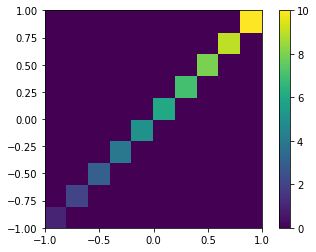

[[ 1  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  0 10]]


In [152]:
mat = np.diag([i for i in range(1,11)])
xmat = np.linspace(-1,1,11)
ymat = np.linspace(-1,1,11)
fig = plt.figure()
ax = fig.add_subplot(111,aspect = 'equal')
im = ax.pcolormesh(xmat,ymat,mat)
fig.colorbar(im, ax = ax)
plt.show()
print(mat)


